# Judge Comparison Experiment

This notebook compares multiple judgment systems to understand which exhibit "Riemann-healthy" error behavior.

We will compare:
- BiasedJudge: Systematic bias increasing with complexity
- NoisyJudge: High random noise
- ConservativeJudge: Tendency toward neutral judgments  
- RadicalJudge: Amplifies extremes

For each judge, we compute Π(x), E(x), and test the ERH.


In [1]:
import sys
import os
from pathlib import Path

# Robust path setup
def setup_paths():
    current_dir = Path(os.getcwd())
    if current_dir.name == 'notebooks':
        simulation_dir = str(current_dir.parent)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    elif current_dir.name == 'simulation':
        simulation_dir = str(current_dir)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    for parent in current_dir.parents:
        if parent.name == 'simulation':
            simulation_dir = str(parent)
            if simulation_dir not in sys.path:
                sys.path.insert(0, simulation_dir)
            return simulation_dir
    for path in ['..', '../simulation', 'simulation']:
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, abs_path)
    return None

setup_paths()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats as scipy_stats
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("Note: ipywidgets not available, interactive features disabled")

from core.action_space import generate_world
from core.judgement_system import BiasedJudge, NoisyJudge, ConservativeJudge, RadicalJudge, batch_evaluate, evaluate_judgement
from core.ethical_primes import compare_error_distributions
from analysis.statistics import compare_judges, generate_report
from visualization.plots import setup_paper_style, plot_multi_judge_errors, plot_judge_comparison

setup_paper_style()
np.random.seed(42)


Note: ipywidgets not available, interactive features disabled


## Configuration

Set parameters for the comparison experiment. Use interactive widgets if available, otherwise modify values directly.


In [2]:
# Configuration parameters
num_actions = 1000
tau = 0.3
X_max = 100

# Judge configurations
judge_configs = {
    'Biased': {'bias_strength': 0.2, 'noise_scale': 0.1},
    'Noisy': {'noise_scale': 0.3},
    'Conservative': {'threshold': 0.5},
    'Radical': {'amplification': 1.5}
}

if WIDGETS_AVAILABLE:
    # Interactive controls
    num_actions_widget = widgets.IntSlider(value=1000, min=500, max=5000, step=500, description='Actions:')
    tau_widget = widgets.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05, description='Tau:')
    
    def update_experiment(num_actions_val, tau_val):
        global num_actions, tau
        num_actions = num_actions_val
        tau = tau_val
        print(f"Updated: num_actions={num_actions}, tau={tau}")
    
    interact = widgets.interactive(update_experiment, num_actions_val=num_actions_widget, tau_val=tau_widget)
    display(interact)
else:
    print(f"Using fixed parameters: num_actions={num_actions}, tau={tau}")


Using fixed parameters: num_actions=1000, tau=0.3


## Generate Action Space and Evaluate Judges


In [3]:
# Generate shared action space
actions = generate_world(num_actions=num_actions, complexity_dist='zipf', random_seed=42)

# Create judges
judges = {
    'Biased': BiasedJudge(**judge_configs['Biased']),
    'Noisy': NoisyJudge(**judge_configs['Noisy']),
    'Conservative': ConservativeJudge(**judge_configs['Conservative']),
    'Radical': RadicalJudge(**judge_configs['Radical'])
}

print(f"Generated {num_actions} actions")
print(f"Created {len(judges)} judges: {', '.join(judges.keys())}")

# Evaluate all judges
results = batch_evaluate(actions, judges, tau=tau)
print("\nEvaluation complete!")


Generated 1000 actions
Created 4 judges: Biased, Noisy, Conservative, Radical

Evaluation complete!


## Basic Comparison

Compare ERH satisfaction and error exponents across judges.


In [4]:
# Compare judges
comparison = compare_judges(results, X_max=X_max)

# Display results
print("Judge Comparison Results:")
print("=" * 80)
for name, metrics in comparison.items():
    erh_status = "SATISFIED" if metrics.get('erh_satisfied', False) else "NOT SATISFIED"
    alpha = metrics.get('estimated_exponent', np.nan)
    print(f"{name:15s}: ERH={erh_status:12s}, α={alpha:7.4f}, R²={metrics.get('r_squared', 0):.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison).T
comparison_df = comparison_df[['estimated_exponent', 'erh_satisfied', 'r_squared', 'growth_rate']]
comparison_df.columns = ['Exponent α', 'ERH Satisfied', 'R²', 'Growth Rate']
print("\nComparison Table:")
print(comparison_df.to_string())


Judge Comparison Results:
Biased         : ERH=NOT SATISFIED, α= 0.0487, R²=0.0017
Noisy          : ERH=NOT SATISFIED, α=-0.7820, R²=0.5473
Conservative   : ERH=NOT SATISFIED, α=-0.1359, R²=0.7940
Radical        : ERH=NOT SATISFIED, α=-0.1519, R²=0.0155

Comparison Table:
             Exponent α ERH Satisfied        R²     Growth Rate
Biased         0.048654         False   0.00174  sublinear_slow
Noisy         -0.782041         False  0.547312  sublinear_slow
Conservative  -0.135933         False  0.793985  sublinear_slow
Radical       -0.151912         False  0.015542  sublinear_slow


## Visualizations

### Side-by-Side Error Growth Comparison


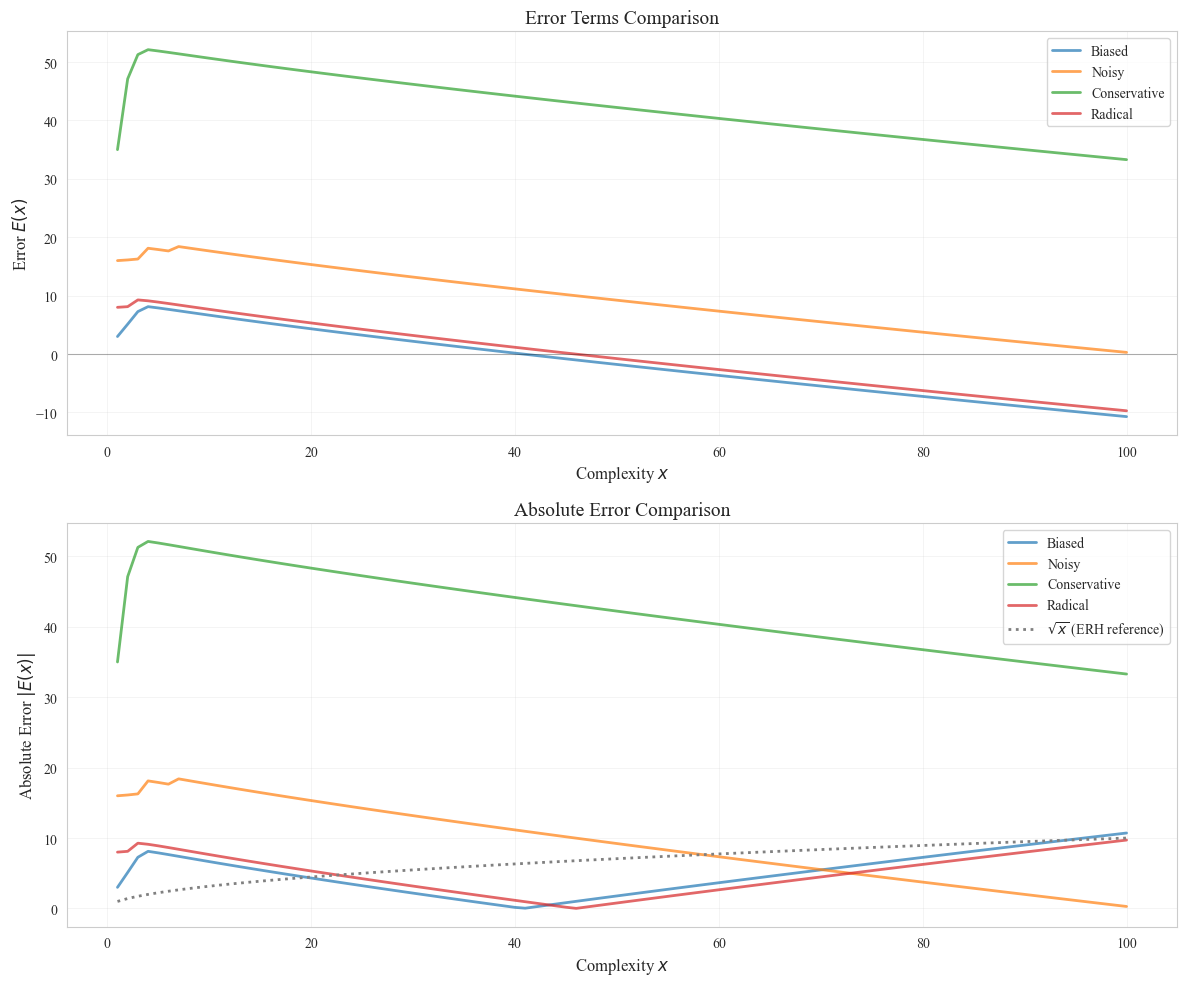

In [5]:
# Plot multi-judge error comparison
comparison_data = compare_error_distributions(results, X_max=X_max)
plot_multi_judge_errors(comparison_data, save_path='../output/figures/02_multi_judge_errors.pdf')
plt.show()


### Judge Performance Heatmap


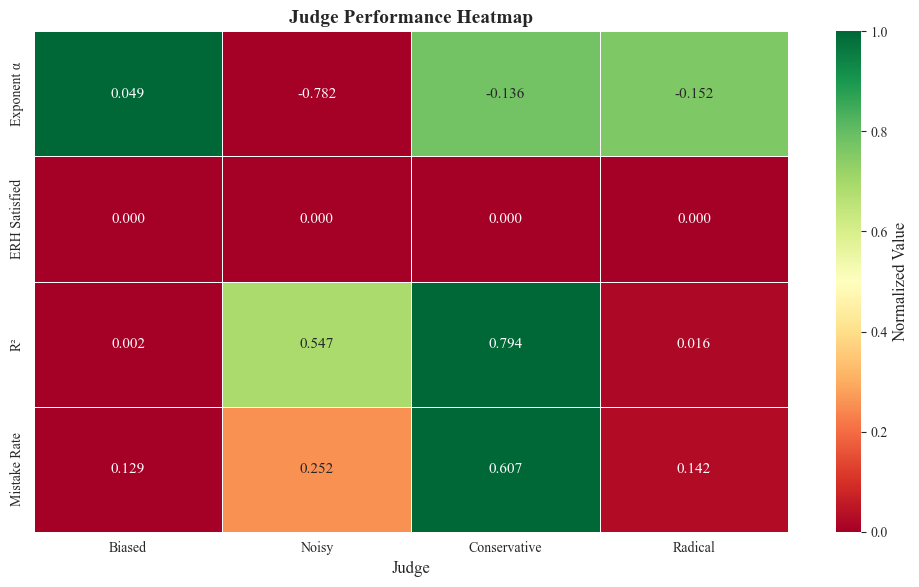

In [6]:
# Create heatmap of judge performance metrics
metrics_data = []
for name, metrics in comparison.items():
    metrics_data.append({
        'Judge': name,
        'Exponent α': metrics.get('estimated_exponent', np.nan),
        'ERH Satisfied': 1 if metrics.get('erh_satisfied', False) else 0,
        'R²': metrics.get('r_squared', 0),
        'Mistake Rate': metrics.get('mistake_rate', np.nan)
    })

heatmap_df = pd.DataFrame(metrics_data).set_index('Judge')
heatmap_df_norm = heatmap_df.copy()
# Normalize for visualization (except ERH Satisfied which is binary)
for col in ['Exponent α', 'R²', 'Mistake Rate']:
    if col in heatmap_df_norm.columns:
        col_min = heatmap_df_norm[col].min()
        col_max = heatmap_df_norm[col].max()
        if col_max > col_min:
            heatmap_df_norm[col] = (heatmap_df_norm[col] - col_min) / (col_max - col_min)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df_norm.T, annot=heatmap_df.T, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)
plt.title('Judge Performance Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/02_judge_heatmap.pdf', dpi=300)
plt.show()


## Statistical Analysis

### Confidence Intervals and Hypothesis Testing


In [7]:
# Statistical analysis: Bootstrap confidence intervals for exponents
def bootstrap_exponent(actions, judge, tau, n_bootstrap=100):
    """Bootstrap estimate of exponent with confidence interval"""
    exponents = []
    for _ in range(n_bootstrap):
        # Resample actions with replacement
        indices = np.random.choice(len(actions), size=len(actions), replace=True)
        resampled_actions = [actions[i] for i in indices]
        
        # Evaluate and compute exponent
        from core.ethical_primes import select_ethical_primes, compute_Pi_and_error, analyze_error_growth
        from core.judgement_system import evaluate_judgement
        evaluate_judgement(resampled_actions, judge, tau=tau)
        primes = select_ethical_primes(resampled_actions)
        if len(primes) > 10:
            Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)
            analysis = analyze_error_growth(E_x, x_vals)
            exp = analysis.get('estimated_exponent', np.nan)
            if not np.isnan(exp):
                exponents.append(exp)
    
    if len(exponents) > 0:
        return {
            'mean': np.mean(exponents),
            'std': np.std(exponents),
            'ci_lower': np.percentile(exponents, 2.5),
            'ci_upper': np.percentile(exponents, 97.5)
        }
    return None

print("Computing bootstrap confidence intervals (this may take a moment)...")
bootstrap_results = {}
for name, judge in judges.items():
    result = bootstrap_exponent(actions, judge, tau, n_bootstrap=50)  # Reduced for speed
    if result:
        bootstrap_results[name] = result
        print(f"{name:15s}: α = {result['mean']:.4f} ± {result['std']:.4f} "
              f"[{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")

# Hypothesis test: Is exponent significantly different from 0.5?
print("\nHypothesis Tests (H0: α = 0.5):")
print("=" * 80)
for name, result in bootstrap_results.items():
    # One-sample t-test
    t_stat = (result['mean'] - 0.5) / (result['std'] / np.sqrt(50))
    p_value = 2 * (1 - scipy_stats.t.cdf(abs(t_stat), df=49))
    significant = p_value < 0.05
    status = "REJECT H0" if significant else "FAIL TO REJECT H0"
    print(f"{name:15s}: t={t_stat:7.3f}, p={p_value:.4f}, {status}")


Computing bootstrap confidence intervals (this may take a moment)...
Biased         : α = -0.0206 ± 0.1488 [-0.3527, 0.1635]
Noisy          : α = -0.7939 ± 0.1830 [-1.0722, -0.5011]


Conservative   : α = -0.1351 ± 0.0072 [-0.1487, -0.1209]


Radical        : α = -0.1795 ± 0.1876 [-0.6273, 0.0706]

Hypothesis Tests (H0: α = 0.5):
Biased         : t=-24.730, p=0.0000, REJECT H0
Noisy          : t=-49.987, p=0.0000, REJECT H0
Conservative   : t=-624.941, p=0.0000, REJECT H0
Radical        : t=-25.612, p=0.0000, REJECT H0


### Correlation Analysis


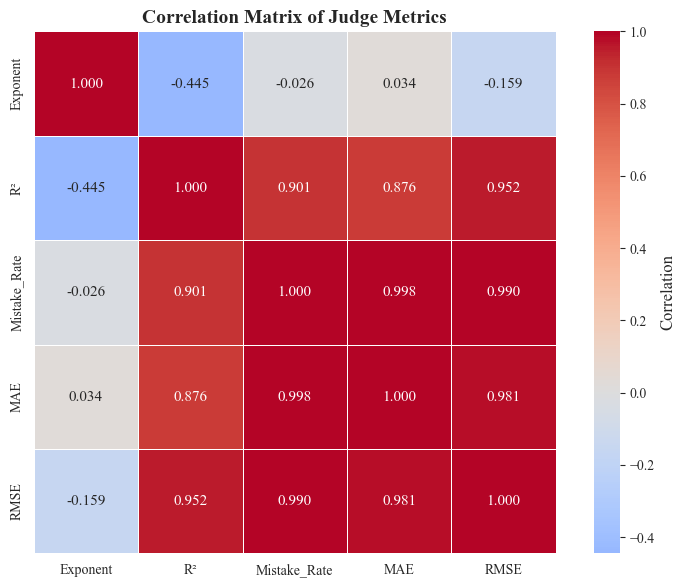


Key Correlations:
Exponent vs R²: -0.445
Exponent vs Mistake_Rate: -0.026
R² vs MAE: 0.876


In [8]:
# Extract all metrics for correlation analysis
all_metrics = []
for name, metrics in comparison.items():
    all_metrics.append({
        'Judge': name,
        'Exponent': metrics.get('estimated_exponent', np.nan),
        'R²': metrics.get('r_squared', 0),
        'Mistake_Rate': metrics.get('mistake_rate', np.nan),
        'MAE': metrics.get('mae', np.nan),
        'RMSE': metrics.get('rmse', np.nan)
    })

metrics_df = pd.DataFrame(all_metrics).set_index('Judge')
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

# Compute correlation matrix
corr_matrix = metrics_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Judge Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/02_correlation_matrix.pdf', dpi=300)
plt.show()

print("\nKey Correlations:")
print(f"Exponent vs R²: {corr_matrix.loc['Exponent', 'R²']:.3f}")
print(f"Exponent vs Mistake_Rate: {corr_matrix.loc['Exponent', 'Mistake_Rate']:.3f}")
print(f"R² vs MAE: {corr_matrix.loc['R²', 'MAE']:.3f}")


## Export Results

Export comparison data and generate detailed report.


In [9]:
# Ensure output directory exists
os.makedirs('../output', exist_ok=True)

# Export comparison table as CSV
comparison_df_full = pd.DataFrame(comparison).T
csv_path = '../output/judge_comparison_table.csv'
comparison_df_full.to_csv(csv_path)
print(f"Exported comparison table to: {csv_path}")

# Export metrics DataFrame
metrics_df.to_csv('../output/judge_metrics.csv')
print(f"Exported metrics to: ../output/judge_metrics.csv")

# Generate detailed markdown report
report = generate_report(results, output_path='../output/judge_comparison_report.md')
print(f"\nGenerated detailed report: ../output/judge_comparison_report.md")
print(f"Report length: {len(report)} characters")

# Display first 1000 characters of report
print("\n" + "=" * 80)
print("Report Preview:")
print("=" * 80)
print(report[:1000])
print("...")


Exported comparison table to: ../output/judge_comparison_table.csv
Exported metrics to: ../output/judge_metrics.csv

Generated detailed report: ../output/judge_comparison_report.md
Report length: 2058 characters

Report Preview:
# Ethical Riemann Hypothesis - Judge Comparison Report

**Number of judges analyzed:** 4

## Summary Table

| Judge | Actions | Primes | Mistake Rate | MAE | Exponent | ERH Satisfied | Growth Rate |
|-------|---------|--------|--------------|-----|----------|---------------|-------------|
| Biased | 1000 | 11 | 0.129 | 0.178 | 0.049 | [FAIL] | sublinear_slow |
| Noisy | 1000 | 22 | 0.252 | 0.210 | -0.782 | [FAIL] | sublinear_slow |
| Conservative | 1000 | 55 | 0.607 | 0.341 | -0.136 | [FAIL] | sublinear_slow |
| Radical | 1000 | 12 | 0.142 | 0.177 | -0.152 | [FAIL] | sublinear_slow |

## Detailed Analysis

### Biased

- **Total Actions:** 1000
- **Ethical Primes:** 11 (1.10%)
- **Mistake Rate:** 0.129
- **Mean Absolute Error:** 0.178
- **RMSE:** 0.205
- **Estim